Mathematica code:


```
(*Define variables*)
Clear[g, t, S, delta]

(*Define S function*)
S[g_, gdot_] := (gdot^2)/(8*(Delta^2 + g^2)^2)

(*Partial derivatives*)
dSdg = D[S[g[t], g'[t]], g[t]]
dSdgd = D[S[g[t], g'[t]], g'[t]]

(*Total time derivative*)
dSdgdt = D[dSdgd, t]


(*Euler-Lagrange equation*)
eulerEq = dSdg - dSdgdt == 0

(*Solve differential equation*)
sol = DSolve[{eulerEq, {g[0] == g0, g[1] == -g0}}, g[t], t]

```



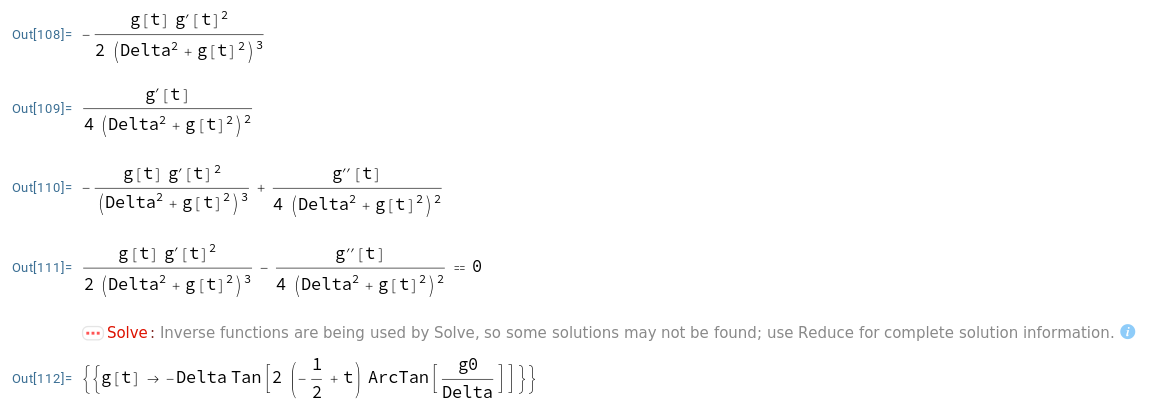

Solution:


```
{{g[t] -> -Delta Tan[2 (-(1/2) + t) ArcTan[g0/Delta]]}}
```



In [20]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

%matplotlib ipympl

In [21]:
font = {
        'weight' : 'bold',
        'size'   : 20}
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', **font)

In [22]:
# Physical parameters
delta = 1 # Energy gap
alpha = -10 * delta
tau = 1.5 # total time evolution
omega_args = {'delta': delta, 'alpha': alpha, 'tau': tau}
g_lin_args = {'tau':tau, 'gc':0}
temperature = 0.1 # Changes p_0
t_0 = 0
t_f = tau

# Formatting parameters
amt_times = 1000 # How many points we calculate
interval_colunas = 100 # Int interval between columns shown in work distr
width = depth = tau/100 # Size of the columns

# Fixed parameters
step = 1/amt_times

ts = np.linspace(t_0, t_f, amt_times)

In [23]:
def g_t(t: float, params_omega: dict):
  # Minimal action solution
  return -params_omega['delta'] * np.tan(((2 * t/params_omega['tau'] - 1))
                                         * np.arctan(params_omega['alpha']/params_omega['delta']))

In [24]:
def g_lin_t(t: float, gvars: dict):
    # Linear ramp solution
    return alpha + 2 * (gvars['gc'] - alpha) * t / gvars['tau']

In [25]:
Hstatic = delta * qutip.sigmax()
Hdinamic = qutip.sigmaz()
H_LZ = [Hstatic, [Hdinamic, g_t]]
H_LZ_lin = [Hstatic, [Hdinamic, g_lin_t]]

def H_LZ_t(t:float, params_omega: dict):
  return Hstatic + Hdinamic * g_t(t, params_omega)

def H_LZ_lin_t(t: float, params: dict):
  return Hstatic + Hdinamic * g_lin_t(t,params)

##Energy levels

In [26]:
gs_dyn = []
es_dyn = []
gs_lin_dyn =[]
es_lin_dyn =[]
for i in ts:
  energies = H_LZ_t(i,omega_args).eigenenergies()
  energies_lin = H_LZ_lin_t(i,g_lin_args).eigenenergies()
  gs_dyn += [energies[0]]
  es_dyn += [energies[1]]
  gs_lin_dyn += [energies_lin[0]]
  es_lin_dyn += [energies_lin[1]]

Text(0.5, 1.0, 'Energy levels, $ \\tau=1.5 $')

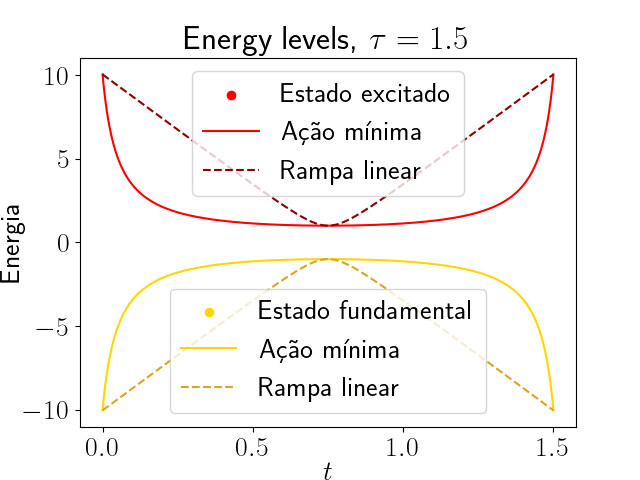

In [27]:
gap_dyn = es_dyn
gap_lin_dyn = es_lin_dyn
gap_dyn_gs = gs_dyn
gap_lin_dyn_gs = gs_lin_dyn

fig2, ax2 = plt.subplots()

scatter21 = ax2.scatter([],[],color='red',label="Estado excitado")
line21, = ax2.plot(ts, gap_dyn, color="red", label="Ação mínima")
line22, = ax2.plot(ts, gap_lin_dyn, color="darkred", label="Rampa linear", linestyle="dashed")

ax2.scatter([],[],alpha=0.0,label=' ')

scatter22 = ax2.scatter([],[],color='gold',label="Estado fundamental")
line23, = ax2.plot(ts, gap_dyn_gs, color="gold", label="Ação mínima")
line24, = ax2.plot(ts, gap_lin_dyn_gs, color="goldenrod", label="Rampa linear", linestyle="dashed")

legend1 = ax2.legend(handles=[scatter21, line21, line22], loc='upper center')
ax2.add_artist(legend1)

legend2 = ax2.legend(handles=[scatter22, line23, line24], loc='lower center')

ax2.set_xlabel('$t$', labelpad=-0.5)
ax2.set_ylabel('Energia', labelpad=-1.0)

title2 = "Energy levels, $ \\tau={} $".format(tau)
ax2.set_title(title2)

## Work distribution

In [28]:
beta=1/temperature
n_beta = 1/(np.exp(-beta)-1)
rho_0 = qutip.thermal_dm(2, n_beta)
evol_total = qutip.propagator(H_LZ, ts,[],args=omega_args)

/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:2380: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


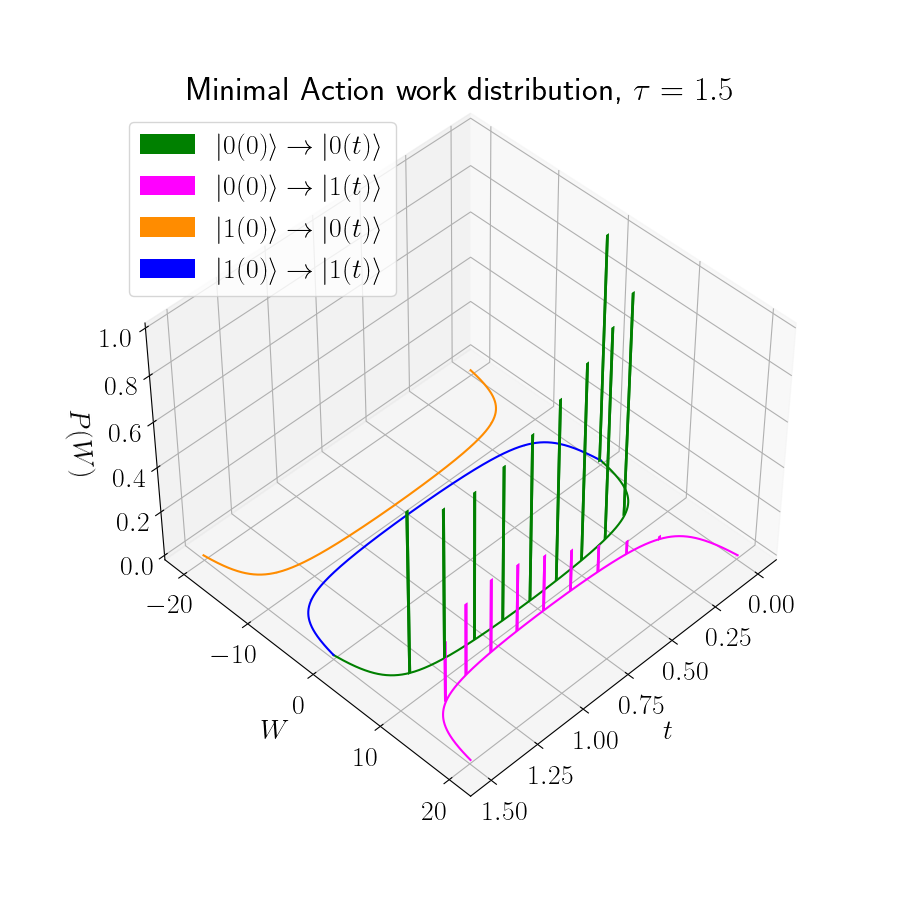

In [29]:
def p_n_m(t):
  ###return [p_00, p_01, p_10, p_11]
  conjaux_0 = np.array(H_LZ_t(0,omega_args).eigenstates()[1])
  conjaux_t = np.array(H_LZ_t(t,omega_args).eigenstates()[1])
  varaux = []
  for i in conjaux_t:
    for j in conjaux_0:
      varaux += [np.linalg.norm(np.linalg.multi_dot([i.dag().full(), evol_total[int(t * amt_times / tau)], j.full()]))**2]
  return varaux

points_00 = []
points_01 = []
points_10 = []
points_11 = []

for t in np.linspace(t_0, t_f - tau/amt_times, amt_times):
  #points = [energy_coord, prob]
  p0_gs = rho_0[1][0][1]
  p0_es = rho_0[0][0][0]
  p_nm = p_n_m(t)

  points_00 += [[gs_dyn[int(t * amt_times / tau)]-gs_dyn[0], p0_gs*p_nm[0]]]
  points_01 += [[es_dyn[int(t * amt_times / tau)]-gs_dyn[0], p0_gs*p_nm[1]]]
  points_10 += [[gs_dyn[int(t * amt_times / tau)]-es_dyn[0], p0_es*p_nm[0]]]
  points_11 += [[es_dyn[int(t * amt_times / tau)]-es_dyn[0], p0_es*p_nm[1]]]

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect(aspect=None, zoom=1.0)

# Adding points

for i in range(0, amt_times, interval_colunas):
    ax.bar3d(ts[i], points_00[i][0], 0, width, depth, points_00[i][1], color='green', shade=False)
    ax.bar3d(ts[i], points_01[i][0], 0, width, depth, points_01[i][1], color='fuchsia', shade=False)
    ax.bar3d(ts[i], points_10[i][0], 0, width, depth, points_10[i][1], color='darkorange', shade=False)
    ax.bar3d(ts[i], points_11[i][0], 0, width, depth, points_11[i][1], color='blue', shade=False)
    
# Axes label
ax.set_xlabel('$t$', labelpad=12.0)
ax.set_ylabel('$W$', labelpad=12.0)
ax.set_zlim(0, 1)
ax.set_zlabel('$P(W)$', labelpad=10.0)

title3 = "Minimal Action work distribution, $ \\tau={} $".format((tau))
ax.set_title(title3)

# Legend
legend_elements = [Patch(facecolor='green', label='$ |0(0) \\rangle \\rightarrow |0(t) \\rangle $'),
                   Patch(facecolor='fuchsia', label='$ |0(0) \\rangle \\rightarrow |1(t) \\rangle $'),
                   Patch(facecolor='darkorange', label='$ |1(0) \\rangle \\rightarrow |0(t) \\rangle $'),
                   Patch(facecolor='blue', label='$ |1(0) \\rangle \\rightarrow |1(t) \\rangle $')]
ax.legend(handles=legend_elements, loc='upper left')

ax.plot(ts, gs_dyn-gs_dyn[0] , zs=0, zdir='z', color='green')
ax.plot(ts, es_dyn-es_dyn[0] , zs=0, zdir='z', color='blue')
ax.plot(ts, gs_dyn-es_dyn[0] , zs=0, zdir='z', color='darkorange')
ax.plot(ts, es_dyn-gs_dyn[0] , zs=0, zdir='z', color='fuchsia')

ax.view_init(45, 45) # View angle
plt.show()

In [30]:
evol_total_lin = qutip.propagator(H_LZ_lin, ts, [], args=g_lin_args)

/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/axes3d.py:2380: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


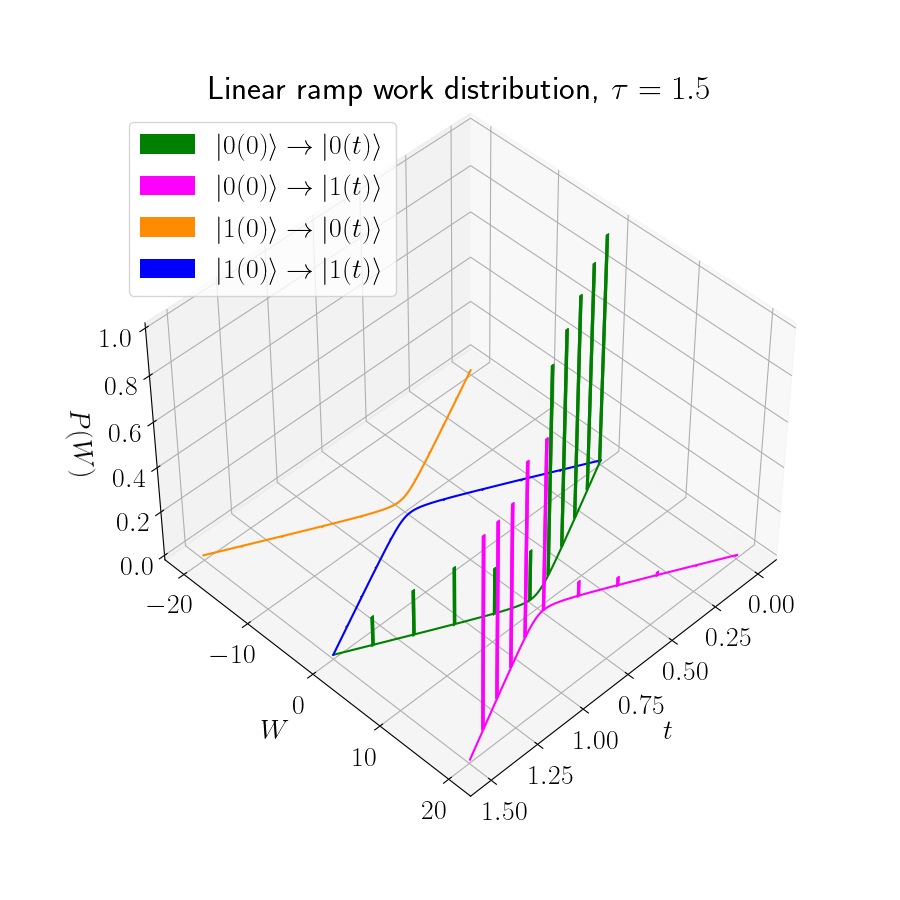

In [31]:
def p_n_m_lin(t):
  ###return [p_00, p_01, p_10, p_11]
  conjaux_0 = np.array(H_LZ_lin_t(t,g_lin_args).eigenstates()[1])
  conjaux_t = np.array(H_LZ_lin_t(t,g_lin_args).eigenstates()[1])
  varaux = []
  for i in conjaux_t:
    for j in conjaux_0:
      varaux += [np.linalg.norm(np.linalg.multi_dot([i.dag().full(), evol_total[int(t * amt_times / tau)], j.full()]))**2]
  return varaux

pointslin_00 = []
pointslin_01 = []
pointslin_10 = []
pointslin_11 = []

for t in np.linspace(t_0, t_f - tau/amt_times, amt_times):
  #points = [energy_coord, prob]
  p0_gs = rho_0[1][0][1]
  p0_es = rho_0[0][0][0]
  p_nm = p_n_m_lin(t)

  pointslin_00 += [[gs_lin_dyn[int(t * amt_times / tau)]-gs_lin_dyn[0], p0_gs*p_nm[0]]]
  pointslin_01 += [[es_lin_dyn[int(t * amt_times / tau)]-gs_lin_dyn[0], p0_gs*p_nm[1]]]
  pointslin_10 += [[gs_lin_dyn[int(t * amt_times / tau)]-es_lin_dyn[0], p0_es*p_nm[0]]]
  pointslin_11 += [[es_lin_dyn[int(t * amt_times / tau)]-es_lin_dyn[0], p0_es*p_nm[1]]]

fig4 = plt.figure(figsize=(9,9))
ax4 = fig4.add_subplot(111, projection='3d')
ax4.set_box_aspect(aspect=None, zoom=1.0)

# Adding points
width2 = tau/100
depth2 = int(abs(max(gs_lin_dyn)-min(gs_lin_dyn)))/100

for i in range(0, amt_times, interval_colunas):
    ax4.bar3d(ts[i], pointslin_00[i][0], 0, width2, depth2, pointslin_00[i][1], color='green', shade=False)
    ax4.bar3d(ts[i], pointslin_01[i][0], 0, width2, depth2, pointslin_01[i][1], color='fuchsia', shade=False)
    ax4.bar3d(ts[i], pointslin_10[i][0], 0, width2, depth2, pointslin_10[i][1], color='darkorange', shade=False)
    ax4.bar3d(ts[i], pointslin_11[i][0], 0, width2, depth2, pointslin_11[i][1], color='blue', shade=False)
    
# Axes label
ax4.set_xlabel('$t$', labelpad=12.0)
ax4.set_ylabel('$W$', labelpad=12.0)
ax4.set_zlim(0, 1)
ax4.set_zlabel('$P(W)$', labelpad=10.0)

title4 = "Linear ramp work distribution, $ \\tau={} $".format((tau))
ax4.set_title(title4)

# Legend
legend_elements = [Patch(facecolor='green', label='$ |0(0) \\rangle \\rightarrow |0(t) \\rangle $'),
                   Patch(facecolor='fuchsia', label='$ |0(0) \\rangle \\rightarrow |1(t) \\rangle $'),
                   Patch(facecolor='darkorange', label='$ |1(0) \\rangle \\rightarrow |0(t) \\rangle $'),
                   Patch(facecolor='blue', label='$ |1(0) \\rangle \\rightarrow |1(t) \\rangle $')]
ax4.legend(handles=legend_elements, loc='upper left')

ax4.plot(ts, (gs_lin_dyn-gs_lin_dyn[0]), zs=0, zdir='z', color='green')
ax4.plot(ts, (es_lin_dyn-es_lin_dyn[0]), zs=0, zdir='z', color='blue')
ax4.plot(ts, (gs_lin_dyn-es_lin_dyn[0]), zs=0, zdir='z', color='darkorange')
ax4.plot(ts, (es_lin_dyn-gs_lin_dyn[0]), zs=0, zdir='z', color='fuchsia')

ax4.view_init(45, 45) # View angle

## Probabilities vs. time

In [32]:
probs_00 = []
probs_01 = []
probs_10 = []
probs_11 = []

probslin_00 = []
probslin_01 = []
probslin_10 = []
probslin_11 = []

for i in range(amt_times):
    probs_00 += [points_00[i][1]]
    probs_01 += [points_01[i][1]]
    probs_10 += [points_10[i][1]]
    probs_11 += [points_11[i][1]]

    probslin_00 += [pointslin_00[i][1]]
    probslin_01 += [pointslin_01[i][1]]
    probslin_10 += [pointslin_10[i][1]]
    probslin_11 += [pointslin_11[i][1]]

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Ground state transition probabilities, $ \\tau=1.5 $')

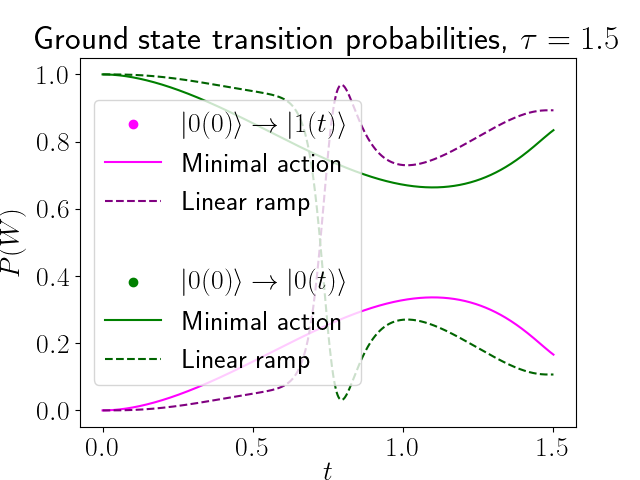

In [33]:
fig5,ax5 = plt.subplots()

# Axes label
ax5.set_xlabel('$t$', labelpad=-0.5)
ax5.set_ylabel('$P(W)$', labelpad=8.0)

ax5.scatter([],[],color='fuchsia',label='$ |0(0) \\rangle \\rightarrow |1(t) \\rangle $')
ax5.plot(ts, probs_01 , color='fuchsia', label='Minimal action')
ax5.plot(ts, probslin_01, color='purple', linestyle='dashed', label='Linear ramp')

ax5.scatter([],[],alpha=0.0,label=' ')

ax5.scatter([],[],color='green',label='$ |0(0) \\rangle \\rightarrow |0(t) \\rangle $')
ax5.plot(ts, probs_00 , color='green', label='Minimal action')
ax5.plot(ts, probslin_00, color='darkgreen', linestyle='dashed', label='Linear ramp')

ax5.legend()

title5 = "Ground state transition probabilities, $ \\tau={} $".format((tau))
ax5.set_title(title5)

Text(0.5, 1.0, 'Ground state transition probabilities, $ \\tau=1.5 $')

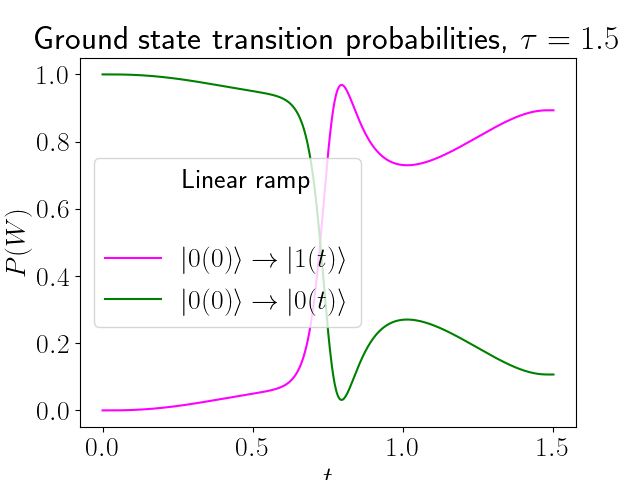

In [34]:
fig5,ax5 = plt.subplots()

# Axes label
ax5.set_xlabel('$t$')
ax5.set_ylabel('$P(W)$')

ax5.scatter([],[],alpha=0.0,label='Linear ramp')
ax5.scatter([],[],alpha=0.0,label=' ')
ax5.plot(ts, probslin_01 , color='fuchsia', label='$ |0(0) \\rangle \\rightarrow |1(t) \\rangle $')
ax5.plot(ts, probslin_00 , color='green', label='$ |0(0) \\rangle \\rightarrow |0(t) \\rangle $')

ax5.legend(loc='center left')

title5 = "Ground state transition probabilities, $ \\tau={} $".format((tau))
ax5.set_title(title5)

Text(0.5, 1.0, 'Excited state transition probabilities, $ \\tau=1.5 $')

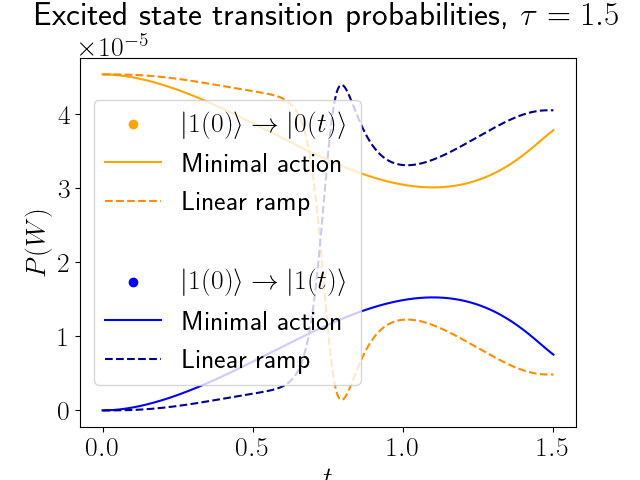

In [35]:
fig6,ax6 = plt.subplots()

# Axes label
ax6.set_xlabel('$t$')
ax6.set_ylabel('$P(W)$')

ax6.scatter([],[],color = 'orange', label='$ |1(0) \\rangle \\rightarrow |0(t) \\rangle $')
ax6.plot(ts, probs_10 , color='orange', label='Minimal action')
ax6.plot(ts, probslin_10, color='darkorange', linestyle='dashed', label='Linear ramp')

ax6.scatter([],[],alpha=0.0,label=' ')

ax6.scatter([],[],color='blue',label='$ |1(0) \\rangle \\rightarrow |1(t) \\rangle$')
ax6.plot(ts, probs_11 , color='blue', label='Minimal action')
ax6.plot(ts, probslin_11, color='darkblue', linestyle='dashed', label='Linear ramp')

ax6.legend()

title6 = "Excited state transition probabilities, $ \\tau={} $".format((tau))
ax6.set_title(title6)

Taking a look at $g(t)/\Delta$:

Text(0.5, 1.0, 'Normalized $ g(t) $, $ \\tau=1.5 $')

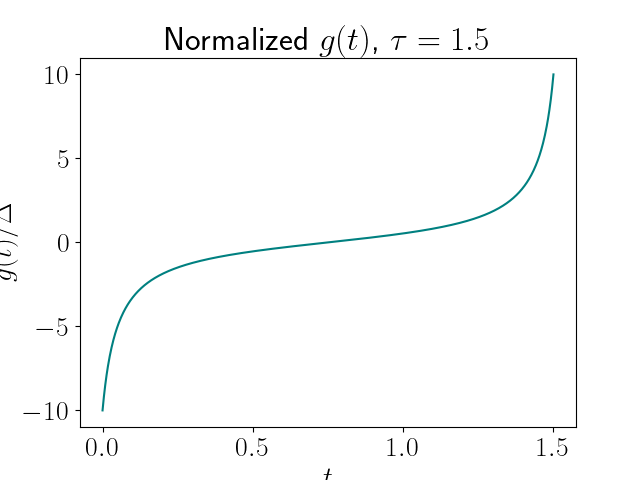

In [40]:
g_values = [g_t(i,omega_args)/delta for i in ts]

fig7,ax7=plt.subplots()

# Axes label
ax7.set_xlabel('$t$')
ax7.set_ylabel('$g(t)/ \\Delta$')
ax7.plot(ts, g_values, color='teal')

title7 = "Normalized $ g(t) $, $ \\tau={} $".format((tau))
ax7.set_title(title7)

## Fidelity vs. $\tau$

In [37]:
t_f_fid = 60
t_0_fid = t_f_fid/amt_times
fidel_interval = np.linspace(t_0_fid,t_f_fid,amt_times)

In [39]:
def f_t(t: float, params_omega: dict):
    return params_omega['alpha'] + (params_omega['alpha2']-params_omega['alpha']) * t / params_omega['tau']

H_linear = [Hstatic, [Hdinamic, f_t]]

fidel = []
fidel_lin = []
for i in fidel_interval:
    gs_0 = H_LZ_t(0,{'delta': delta, 'alpha': alpha, 'tau': i}).eigenstates()[1][0]
    gs_t = H_LZ_t(i,{'delta': delta, 'alpha': alpha, 'tau': i}).eigenstates()[1][0]
    options = qutip.solver.Options(nsteps = 100000000, order=5)
    evol = qutip.propagator(H_LZ, [t_0, i],[],args={'delta': delta, 'alpha': alpha, 'tau': i},options=options)
    evol_lin = qutip.propagator(H_linear, [t_0, i],[],args={'alpha': alpha, 'alpha2': -alpha, 'tau': i},options=options)
    fidel += [np.linalg.norm(np.linalg.multi_dot([gs_t.dag(),evol,gs_0]))**2]
    fidel_lin += [np.linalg.norm(np.linalg.multi_dot([gs_t.dag(),evol_lin,gs_0]))**2]

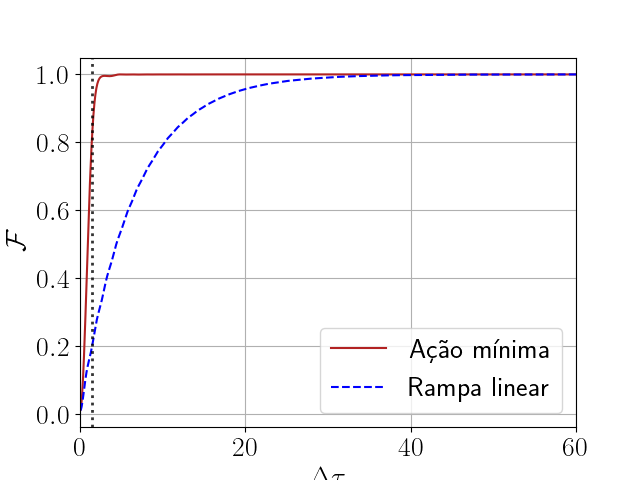

In [41]:
# Plot the results
fig, ax = plt.subplots()

# Plot the results for linear ramp and action ramp
ax.plot(fidel_interval, fidel, color='firebrick', label='Ação mínima')
ax.plot(fidel_interval, fidel_lin, color='blue', linestyle='dashed', label='Rampa linear')

# Add vertical lines at specific points
ax.axvline(x=1.5, color='black', linestyle='dotted', linewidth=2, alpha=0.8)

# Add labels and grid
ax.set_xlabel(r'$\Delta \tau$')
ax.set_ylabel(r'$\mathcal{F}$')
ax.legend()
ax.grid()

# Show the plot
plt.xlim(0, t_f_fid)

plt.show()